# Imports

In [241]:
import time,pickle,itertools
from datetime import date
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from random import randint,uniform
from collections import Counter

from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV,HalvingRandomSearchCV,HalvingGridSearchCV,cross_val_score
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler,OneHotEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, make_scorer

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,Matern
from sklearn.kernel_ridge import KernelRidge
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR,NuSVR

from scipy.stats import skew

# import optuna
# import umap

import warnings
warnings.filterwarnings("ignore") 
warnings.filterwarnings("ignore", category=RuntimeWarning) 

# Chemistry
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw.MolDrawing import MolDrawing,DrawingOptions
DrawingOptions.bondLineWidth=1.8
from rdkit.Chem import PandasTools

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [242]:
ee_cap = 99.99

def ee2g(ee,T_C=25): # T in Celsius
    R = 8.31446261815324 # J/K/mol
    J_cal = 4.184 # 1 kcal = 4.184 kJ
    K_C = 273.15
    T_K = T_C + K_C
    try: # individual number
        if ee >= 100:
#             print("capping ee",ee)
            ee = ee_cap
        if ee <= -100:
#             print("capping ee",ee)        
            ee = ee_cap
    except ValueError: # array
        if (ee >= 100).any():
#             print("capping ee",ee[np.where(ee >= 100)[0]])
            ee[np.where(ee >= 100)[0]] = ee_cap
        if (ee <= -100).any():
#             print("capping ee",ee[np.where(ee <= 100)[0]])
            ee[np.where(ee <= 100)[0]] =  ee_cap
    
    er = (100+ee)/(100-ee)
    ddg = R*T_K*np.log(er) / J_cal/1000  # kcal/mol
    return(ddg)

def g2ee(ddg,T_C=25):
    R = 8.31446261815324 # J/K/mol
    J_cal = 4.184 # 1 kcal = 4.184 kJ
    K_C = 273.15
    T_K = T_C + K_C
    er = np.exp(ddg/(R*T_K)*J_cal*1000)
    ee = -100*(1-er)/(1+er)
    return(ee)

def ee2g_mae(y_true_ee,y_pred_ee,T_C=25):
    """Returns mean absolute error of ee-values converted to relative free energies in kcal/mol"""
    y_true_ddg = ee2g(y_true_ee,T_C)
    y_pred_ddg = ee2g(y_pred_ee,T_C)
    
    return(mean_absolute_error(y_true_ddg,y_pred_ddg))

def ee2g_rmse(y_true_ee,y_pred_ee,T_C=25):
    """Returns root mean squared error of ee-values converted to
    relative free energies in kcal/mol"""
    y_true_ddg = ee2g(y_true_ee,T_C)
    y_pred_ddg = ee2g(y_pred_ee,T_C)
    
    return(mean_squared_error(y_true_ddg,y_pred_ddg,squared=False))

def ee2g_r2_score(y_true_ee,y_pred_ee,T_C=25):     
    """Returns R2 score of ee-values converted to relative free energies in kcal/mol"""
    y_true_ddg = ee2g(y_true_ee,T_C)
    y_pred_ddg = ee2g(y_pred_ee,T_C)
    
    return(r2_score(y_true_ddg,y_pred_ddg))
    
def fp_to_array(fp,fp_size = 2**10):
# hiermit kann man rdkit sparse int arrays in numpy arrays mit bestimmter laenge umwandeln
# von Marwin Segler
    nfp = np.zeros((fp_size,),np.int8)
    for idx,v in fp.GetNonzeroElements().items():
            nidx = idx % fp_size
            nfp[nidx]+=int(v)
    return(nfp)

def smi_fp(smi,fp_size = 2**10):
    mol = Chem.MolFromSmiles(smi)
    fpob = AllChem.GetMorganFingerprint(mol, 2)
    fpvect = fp_to_array(fpob,fp_size)
    return(fpvect)

# prepare datasets

In [243]:
test_size = 0.2
num_trials = 2     # repeat modeling incl. HP-optimization for this many random splits
verbose = False    # True not recommended for random state-averaging runs
verbose_min = True # more minimal output, recommended
datasets = {}
fp_size=2**10

settings = {}
sep=";" # separator in the .csv files

# -- for descriptor models -- 
settings["Toste_Desc"] = {
    "filefolder": "_descriptor_data/",
    "filename": "Toste_JACS.csv",
    "features":"descriptors",
    "y_column": "DDG_measured",
    "usecolumns": (3,-6),
    "origdomain": "ddg",
    "T":25,
}

settings["Biscoe_Desc"] = {
    "filefolder": "_descriptor_data/",
    "filename": "alkyl_suzuki_final parameters.csv",
    "features":"descriptors",
    "y_column": "ddg es",
    "usecolumns": (2,-1),
    "origdomain": "ddg",
    "T":100,
}

settings["Doyle_Desc"] = {
    "filefolder": "_descriptor_data/",
    "filename": "Doyle_M062X-def2TVZP_flat.csv",
    "features":"descriptors",
    "y_column": "y_ddG",
    "usecolumns": (1,23),
    "origdomain": "ddg",  
    "T":25,
}

settings["Sunoj_Desc"] = {
    "filefolder": "_descriptor_data/",
    "filename": "sunojdata_clean_nomissingT.csv",
    "features":"descriptors",
    "y_column": "%ee",
    "usecolumns": (1,-25),
    "origdomain": "ee",  
    "T":"T",
}

settings["Sunoj_JPC_Desc"] = {
    "filefolder": "_descriptor_data/",
    "filename": "sunoj_jpc.csv",
    "features":"descriptors",
    "y_column": "ee",
    "usecolumns": (1,-25),
    "origdomain": "ee",  
    "T":25, # this is almost certainly not true but the data in this paper doesn't include T and I'm not digging through the original articles
}

settings["HongAckermann_Desc"] = {
    "filefolder": "_descriptor_data/",
    "filename": "HongAckermann_tsfeats.csv",
    "features":"descriptors",
    "y_column": "ddG",
    "usecolumns": (1,-1),
    "origdomain": "ddg",      
    "T":"Temperature",
}

settings["Denmark_OPRD_Desc"] = {
    "filefolder": "_descriptor_data/",
    "filename": "op1c00155_si_002_descr.csv",
    "features":"descriptors",
    "y_column": "ee",
    "usecolumns": (6,-1),
    "origdomain": "ee",
    "T":4,
}

# -------------------------------------------
# -- for fingerprint models --

settings["Sunoj_DD_2_FP"] = {
    "filefolder": "_smiles_data/",
    "filename": "sunoj_DD_reaction-2.csv",
    "features": "fingerprint",
    "y_column": "ee",
    "smi_column": "smiles",
    "origdomain": "ee",
    "T":25, # not sure if correct throughout data
}

settings["Sunoj_DD_3_FP"] = {
    "filefolder": "_smiles_data/",
    "filename": "sunoj_DD_reaction-3.csv",
    "features": "fingerprint",
    "y_column": "ee",
    "smi_column": "smiles",
    "origdomain": "ee",
    "T":25,# not given in this paper, would need to look up original
}

settings["Denmark_OPRD_FP"] = {
    "filefolder": "_smiles_data/",
    "filename": "op1c00155_si_002_smi.csv",
    "features": "fingerprint",
    "y_column": "ee",
    "smi_column": "Smiles",
    "origdomain": "ee",  
    "T":4,
}

# Modeling

In [244]:
show = list(itertools.product(["ee","ee2ddg","ddg"],["R2_test","RMSE_test","MAErel_test"])) # for displaying the results in the end

def run_model(X_train,X_test,y_train,y_test,T_train,T_test,modelname,model,domain="ddg",verbose=True):
    start = time.time()

    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train).reshape(-1)
    y_test_pred = model.predict(X_test).reshape(-1)

    r2_train = r2_score(y_train,y_train_pred)
    r2_test = r2_score(y_test,y_test_pred)

    rmse_train =  mean_squared_error(y_train,y_train_pred, squared = False) 
    rmse_test =  mean_squared_error(y_test,y_test_pred, squared = False)    
    
    mae_train =  mean_absolute_error(y_train,y_train_pred) 
    mae_test =  mean_absolute_error(y_test,y_test_pred)       
    
    y_combine = np.concatenate((y_train,y_test))
    y_std = y_combine.std()
    maerel_train =  mae_train/y_std
    maerel_test =  mae_test/y_std

    results = {
     (domain,"R2_train"):r2_train,
     (domain,"R2_test"):r2_test,
     (domain,"RMSE_train"):rmse_train,
     (domain,"RMSE_test"):rmse_test,
     (domain,"MAE_train"):mae_train,
     (domain,"MAE_test"):mae_test,
     (domain,"MAErel_train"):maerel_train,
     (domain,"MAErel_test"):maerel_test,
    }
    
    if domain == "ee":
        rmse_train_ddg = ee2g_rmse(y_train,y_train_pred,T_train)
        rmse_test_ddg = ee2g_rmse(y_test,y_test_pred,T_test)    
        mae_train_ddg = ee2g_mae(y_train,y_train_pred,T_train)
        mae_test_ddg = ee2g_mae(y_test,y_test_pred,T_test)    
        r2_train_ddg = ee2g_r2_score(y_train,y_train_pred,T_train)
        r2_test_ddg = ee2g_r2_score(y_test,y_test_pred,T_test)
        
        y_std_ddg = ee2g(y_combine,np.concatenate((T_train,T_test))).std()
        maerel_train_ddg =  mae_train_ddg/y_std_ddg
        maerel_test_ddg =  mae_test_ddg/y_std_ddg
        
        results[("ee2ddg","R2_train")] = r2_train_ddg
        results[("ee2ddg","R2_test")] = r2_test_ddg
        results[("ee2ddg","RMSE_train")] = rmse_train_ddg
        results[("ee2ddg","RMSE_test")] = rmse_test_ddg
        results[("ee2ddg","MAE_train")] = mae_train_ddg
        results[("ee2ddg","MAE_test")] = mae_test_ddg
        results[("ee2ddg","MAErel_train")] = maerel_train_ddg
        results[("ee2ddg","MAErel_test")] = maerel_test_ddg
            
    if verbose:
        print("\n\n",modelname)
        print("\nBest Model:")

        if modelname == "RidgeCV":
            print(f"Ridge(alpha={model.alpha_})")
        elif modelname == "LassoCV": 
            print(f"Lasso(alpha={model.alpha_})")
        elif modelname == "ElasticNetCV": 
            print(f"ElasticNet(alpha={model.alpha_},l1_ratio={model.l1_ratio_})")
        else:
            try:
                print(model.best_estimator_)
            except:
                print(model)

            try:
                print(f"\nHalving Iterations:{model.n_iterations_}")
            except:
                pass

            try:
                print(f"\nIterations:{model.cv_results_['mean_test_score'].shape}")
            except:
                pass

        try:
            print(f"\nBest CV Score:{model.best_score_:.2f}")
        except:
            pass

        print(f"\nTraining:\nR^2 = {r2_train:.2f}, RMSE = {rmse_train:.2f}, MAE = {mae_train:.2f}\n\ntest:\nR^2 = {r2_test:.2f}, RMSE = {rmse_test:.2f}, MAE = {mae_test:.2f}")

        if domain == "ee":
            print(f"\nScores converted to ddG(kcal/mol)\nTraining:\nR^2 = {r2_train_ddg:.2f}, RMSE = {rmse_train_ddg:.2f}, MAE = {mae_train_ddg}\n\ntest:\nR^2 = {r2_test_ddg:.2f}, RMSE = {rmse_test_ddg:.2f}, MAE = {mae_test_ddg}")

        plt.figure(figsize=(5,5))
        plt.scatter(y_train,y_train_pred, label = "train", alpha = 0.5, marker="s", color = "black", s = 10)
        plt.scatter(y_test,y_test_pred, label = "test", alpha = 0.5, marker="s", color = "red", s = 10)
        plt.legend(loc='lower right')
        plt.xlabel("y measured",fontsize=10)
        plt.ylabel("y predicted",fontsize=10)
        plt.show()

    end = time.time()    
    if end - start > 5:
        print(f"{modelname} time: {(end - start):.0f} sec")
    
    return(results)

## Hyperparameter spaces, Model types

In [134]:
parameters_knr = {
    "n_neighbors": np.linspace(1,20,20,dtype=int),
}

parameters_krr_poly = {
    "alpha": np.logspace(-8,4,50),
    "degree": [2,3,4]}

parameters_krr_rbf = {
    "alpha": np.logspace(-8,4,50),}

rbf_kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
matern_kernel = 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2), nu=1.5)

parameters_gpr = {
    "alpha": np.logspace(-7,2,10),
    "kernel": [rbf_kernel,
               matern_kernel],
}

parameters_rf  = {'max_depth': [1,2,4,8,None] ,# np.linspace(1,8,8,dtype=int), 
                  'max_features': ["sqrt",0.5,None], 
                  'min_samples_split': np.linspace(2,10,9,dtype=int), 
                  'min_samples_leaf': np.linspace(1,5,5,dtype=int), 
                  'n_estimators': np.linspace(50,500,10,dtype=int), 
                  'max_samples': np.linspace(0.01,1.0,10),
                 }

parameters_gbr = {'learning_rate': [0.01,0.05,0.1,0.5], 
                  'max_depth': np.linspace(4,8,4,dtype=int), 
                  'max_features': ["sqrt",0.5,None], 
                  'min_samples_leaf': np.linspace(1,5,5,dtype=int), 
                  'n_estimators': np.linspace(50,250,9,dtype=int), 
                  'subsample': [0.5,0.6,0.7,0.8,0.9,1.0]}

parameters_etr = {'max_depth': [1,2,4,8,None] ,# np.linspace(1,8,8,dtype=int), 
                  'max_features': ["sqrt",0.5,None], 
                  'min_samples_split': np.linspace(2,6,5,dtype=int), 
                  'min_samples_leaf': np.linspace(1,5,5,dtype=int), 
                  'n_estimators': np.linspace(50,500,10,dtype=int), 
#                   'max_samples': np.linspace(0.01,1.0,10),    
}
models = {
# Linear
"LinearRegression": linear_model.LinearRegression(),
"RidgeCV": linear_model.RidgeCV(alphas = np.logspace(-4,3,100)),
"LassoCV": linear_model.LassoCV(max_iter = 10000, n_jobs = -4),   
"LarsCV": linear_model.LarsCV(normalize=False, n_jobs = -4), 
"LassoLarsCV": linear_model.LassoLarsCV(normalize=False, n_jobs = -4),
"ElasticNetCV": linear_model.ElasticNetCV(l1_ratio = [.1, .5, .7, .9, .95, .99], n_alphas=16,#alphas = np.logspace(-4,3,16), 
                                          max_iter = 10000, n_jobs = -4, cv=3, random_state = 0) ,    
    
# non-linear parametric
"KernelRidge_poly_CV": GridSearchCV(KernelRidge(kernel="poly"), parameters_krr_poly, n_jobs = -4),
"KernelRidge_rbf_CV": GridSearchCV(KernelRidge(kernel="rbf"), parameters_krr_rbf, n_jobs = -4),
"GaussianProcess_CV": GridSearchCV(GaussianProcessRegressor(random_state = 42), parameters_gpr, n_jobs = -4),
        
# tree-based
"GradientBoostingRegressor_CV_hrs0": HalvingRandomSearchCV(GradientBoostingRegressor(), 
       param_distributions = parameters_gbr,
       n_jobs = -4, cv = 3, random_state = 42),
"GradientBoostingRegressor_CV_hrs1": HalvingRandomSearchCV(GradientBoostingRegressor(), 
       param_distributions = {i:parameters_gbr[i] for i in parameters_gbr.keys() if i!='n_estimators'},
       resource = "n_estimators",max_resources=250,
       n_jobs = -4, cv = 3, random_state = 42),
"GradientBoostingRegressor_CV_hrs2": HalvingRandomSearchCV(GradientBoostingRegressor(), 
       param_distributions = {i:parameters_gbr[i] for i in parameters_gbr.keys() if i!='min_samples_leaf'},
       resource = "min_samples_leaf",max_resources=7,
       n_jobs = -4, cv = 3, random_state = 42),
"GradientBoostingRegressor_CV_rs": RandomizedSearchCV(GradientBoostingRegressor(), 
       param_distributions = parameters_gbr, 
       n_iter = 100, n_jobs = -4, cv = 3, random_state = 42),      
"RandomForestRegressor_CV_hrs0": HalvingRandomSearchCV(RandomForestRegressor(n_jobs=1), 
       param_distributions = parameters_rf, 
       n_jobs = -4, cv = 3, random_state = 42),  
"RandomForestRegressor_CV_rs": RandomizedSearchCV(RandomForestRegressor(n_jobs=1), 
       param_distributions = parameters_rf, 
       n_iter = 100, n_jobs = -4, cv = 3, random_state = 42),  
"ExtraTreesRegressor_CV_rs":RandomizedSearchCV(ExtraTreesRegressor(n_jobs=1), 
       param_distributions = parameters_etr, 
       n_iter = 100, n_jobs = -4, cv = 3, random_state = 42),
"ExtraTreesRegressor_CV_hrs2": HalvingRandomSearchCV(ExtraTreesRegressor(n_jobs=1), 
       param_distributions = {i:parameters_etr[i] for i in parameters_etr.keys() if i!='min_samples_leaf'},
       resource = "min_samples_leaf",max_resources=7,
       n_jobs = -4, cv = 3, random_state = 42),
    
# other
"KNeighborsRegressor": GridSearchCV(KNeighborsRegressor(), parameters_knr, n_jobs = -4), 

}


 ---------------------------------------------------------------------------------------------------- 
 ---------------------------------------------------------------------------------------------------- 
 Toste_Desc
(37,)
(37,)
(37, 39)


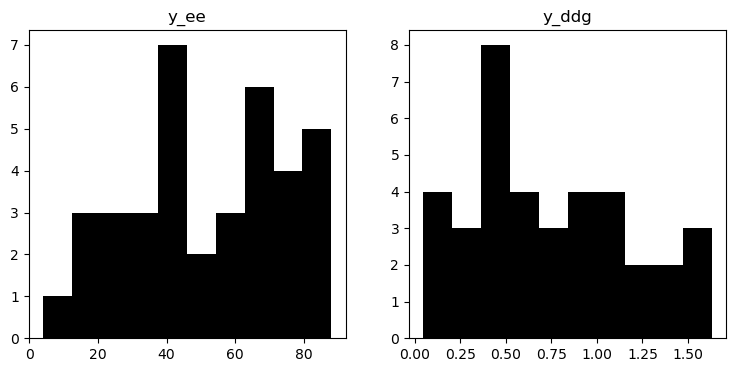

          min,  mean,   max, stdev
y_ee      4.0,  51.3,  88.0,  24.0
y_ddg    0.05,  0.75,  1.63,  0.44
0
1
ExtraTreesRegressor_CV_rs time: 5 sec
ExtraTreesRegressor_CV_rs time: 5 sec


ee                               \
                                  R2_train R2_test RMSE_train RMSE_test   
LinearRegression                      1.00 -206.22       0.00    194.11   
RidgeCV                               0.85    0.56       9.23     14.61   
LassoCV                               0.82    0.58      10.05     14.03   
LarsCV                                0.44    0.38      17.53     16.72   
LassoLarsCV                           0.82    0.59      10.01     13.98   
ElasticNetCV                          0.89    0.62       7.97     13.65   
KernelRidge_poly_CV                   0.95    0.49       5.08     15.44   
KernelRidge_rbf_CV                    1.00    0.09       0.62     19.75   
GaussianProcess_CV                    0.97    0.66       3.68     12.96   
GradientBoostingRegressor_CV_hrs0     0.98    0.20       3.41     17.29   
GradientBoostingRegressor_CV_hrs1     1.00    0.16       0.05     17.25   
GradientBoostingRegressor_CV_hrs2     1.00    0.10       1.06     18.89   
GradientBoostingRegressor_CV_rs       0.98    0.14       2.18     19.90   
RandomForestRegressor_CV_hrs0        -0.02   -0.12      23.76     22.49   
RandomForestRegressor_CV_rs           0.69    0.30      13.08     16.97   
ExtraTreesRegressor_CV_rs             0.94    0.55       4.33     14.20   
ExtraTreesRegressor_CV_hrs2           0.62    0.22      12.96     18.59   
KNeighborsRegressor                   0.52    0.58      16.32     13.51   

                                                                               \
                                  MAE_train MAE_test MAErel_train MAErel_test   
LinearRegression                       0.00   159.83         0.00        6.76   
RidgeCV                                7.39    12.48         0.31        0.53   
LassoCV                                8.08    12.19         0.34        0.52   
LarsCV                                14.86    14.22         0.63        0.60   
LassoLarsCV                            8.05    12.09         0.34        0.51   
ElasticNetCV                           6.24    11.49         0.26        0.49   
KernelRidge_poly_CV                    3.75    12.68         0.16        0.54   
KernelRidge_rbf_CV                     0.45    14.85         0.02        0.63   
GaussianProcess_CV                     2.71    10.35         0.11        0.44   
GradientBoostingRegressor_CV_hrs0      2.36    13.75         0.10        0.58   
GradientBoostingRegressor_CV_hrs1      0.04    13.41         0.00        0.57   
GradientBoostingRegressor_CV_hrs2      0.77    13.71         0.03        0.58   
GradientBoostingRegressor_CV_rs        1.61    14.90         0.07        0.63   
RandomForestRegressor_CV_hrs0         20.49    20.17         0.87        0.85   
RandomForestRegressor_CV_rs           10.89    14.30         0.46        0.61   
ExtraTreesRegressor_CV_rs              3.53    11.69         0.15        0.49   
ExtraTreesRegressor_CV_hrs2           10.63    17.10         0.45        0.72   
KNeighborsRegressor                   11.82    10.61         0.50        0.45   

                                    ee2ddg          ...                   \
                                  R2_train R2_test  ... MAErel_train_std   
LinearRegression                      1.00 -138.32  ...             0.00   
RidgeCV                               0.84    0.46  ...             0.05   
LassoCV                               0.80    0.51  ...             0.05   
LarsCV                                0.39    0.35  ...             0.03   
LassoLarsCV                           0.80    0.51  ...             0.04   
ElasticNetCV                          0.89    0.55  ...             0.05   
KernelRidge_poly_CV                   0.93    0.46  ...             0.04   
KernelRidge_rbf_CV                    1.00    0.30  ...             0.03   
GaussianProcess_CV                    0.97    0.65  ...             0.11   
GradientBoostingRegressor_CV_hrs0     0.98    0.20  ...             0.02   
Gradie


 ---------------------------------------------------------------------------------------------------- 
 ---------------------------------------------------------------------------------------------------- 
 Biscoe_Desc
(24,)
(24,)
(24, 140)


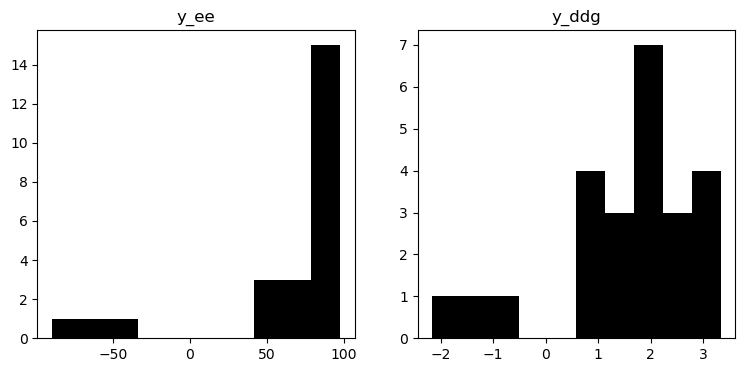

          min,  mean,   max, stdev
y_ee    -89.7,  62.2,  97.8,  52.3
y_ddg   -2.16,  1.54,  3.33,  1.36
0
ExtraTreesRegressor_CV_rs time: 5 sec
ExtraTreesRegressor_CV_rs time: 5 sec
1
ExtraTreesRegressor_CV_rs time: 5 sec
ExtraTreesRegressor_CV_rs time: 5 sec


ee                               \
                                  R2_train R2_test RMSE_train RMSE_test   
LinearRegression                      1.00    0.36       0.00     24.95   
RidgeCV                               0.96    0.08       9.88     26.94   
LassoCV                               0.99    0.01       4.26     27.86   
LarsCV                                0.68    0.36      29.86     28.09   
LassoLarsCV                           0.99    0.02       4.86     27.60   
ElasticNetCV                          0.97    0.06       8.20     27.30   
KernelRidge_poly_CV                   1.00    0.46       0.22     23.57   
KernelRidge_rbf_CV                    1.00    0.11       0.00     27.66   
GaussianProcess_CV                    1.00    0.42       1.46     23.16   
GradientBoostingRegressor_CV_hrs0     0.98   -0.54       7.85     32.22   
GradientBoostingRegressor_CV_hrs1     1.00   -2.29       0.32     42.04   
GradientBoostingRegressor_CV_hrs2     0.99   -0.80       3.63     37.67   
GradientBoostingRegressor_CV_rs       1.00   -1.90       0.00     47.86   
RandomForestRegressor_CV_hrs0        -0.02   -0.99      53.86     43.83   
RandomForestRegressor_CV_rs           0.69    0.52      29.48     24.27   
ExtraTreesRegressor_CV_rs             0.63   -0.16      32.40     35.67   
ExtraTreesRegressor_CV_hrs2           0.64    0.32      32.22     27.42   
KNeighborsRegressor                   1.00    0.23       0.00     31.29   

                                                                               \
                                  MAE_train MAE_test MAErel_train MAErel_test   
LinearRegression                       0.00    17.92         0.00        0.35   
RidgeCV                                7.87    20.60         0.15        0.40   
LassoCV                                3.45    23.38         0.07        0.46   
LarsCV                                19.00    16.68         0.37        0.33   
LassoLarsCV                            3.94    23.83         0.08        0.47   
ElasticNetCV                           6.69    20.72         0.13        0.41   
KernelRidge_poly_CV                    0.17    17.50         0.00        0.34   
KernelRidge_rbf_CV                     0.00    23.34         0.00        0.46   
GaussianProcess_CV                     1.17    18.10         0.02        0.35   
GradientBoostingRegressor_CV_hrs0      4.15    26.52         0.08        0.52   
GradientBoostingRegressor_CV_hrs1      0.15    28.17         0.00        0.55   
GradientBoostingRegressor_CV_hrs2      2.12    26.46         0.04        0.52   
GradientBoostingRegressor_CV_rs        0.00    36.21         0.00        0.71   
RandomForestRegressor_CV_hrs0         32.84    34.33         0.64        0.67   
RandomForestRegressor_CV_rs           17.31    19.92         0.34        0.39   
ExtraTreesRegressor_CV_rs             19.28    29.26         0.38        0.57   
ExtraTreesRegressor_CV_hrs2           20.73    23.37         0.41        0.46   
KNeighborsRegressor                    0.00    18.52         0.00        0.36   

                                    ee2ddg          ...                   \
                                  R2_train R2_test  ... MAErel_train_std   
LinearRegression                      1.00   -3.87  ...             0.00   
RidgeCV                               0.40  -10.27  ...             0.00   
LassoCV                               0.75  -14.90  ...             0.25   
LarsCV                                0.51    0.56  ...             0.05   
LassoLarsCV                           0.71  -14.92  ...             0.17   
ElasticNetCV                          0.45  -10.36  ...             0.06   
KernelRidge_poly_CV                   1.00  -10.20  ...             0.02   
KernelRidge_rbf_CV                    1.00    0.28  ...             0.00   
GaussianProcess_CV                    0.76   -2.84  ...             0.18   
GradientBoostingRegressor_CV_hrs0     0.93  -12.76  ...             0.04   
Gradie


 ---------------------------------------------------------------------------------------------------- 
 ---------------------------------------------------------------------------------------------------- 
 Doyle_Desc
(29,)
(29,)
(29, 22)


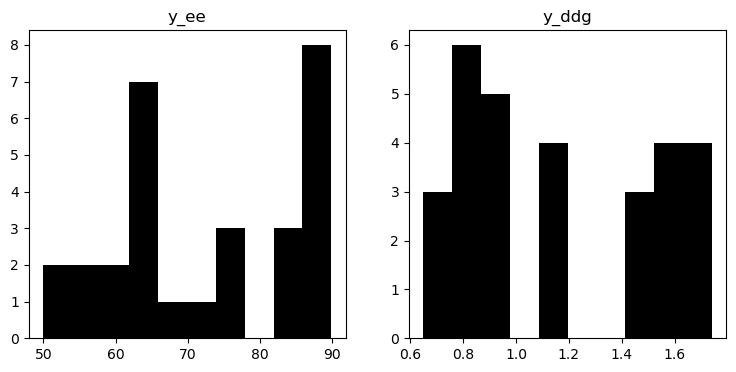

          min,  mean,   max, stdev
y_ee     49.9,  72.4,  89.9,  13.3
y_ddg    0.65,  1.16,  1.74,  0.37
0
1


ee                               \
                                  R2_train R2_test RMSE_train RMSE_test   
LinearRegression                      1.00  -23.44       0.00     56.96   
RidgeCV                               0.92   -0.51       3.57     14.29   
LassoCV                               0.92   -0.59       3.48     14.38   
LarsCV                                0.73    0.50       6.57      8.95   
LassoLarsCV                           0.92   -0.59       3.50     14.36   
ElasticNetCV                          0.92   -0.70       3.42     14.95   
KernelRidge_poly_CV                   0.98    0.30       1.72     10.20   
KernelRidge_rbf_CV                    1.00   -3.17       0.02     22.83   
GaussianProcess_CV                    0.88    0.10       3.06     11.33   
GradientBoostingRegressor_CV_hrs0     0.99    0.44       1.05      9.35   
GradientBoostingRegressor_CV_hrs1     1.00    0.29       0.00     10.31   
GradientBoostingRegressor_CV_hrs2     0.99    0.29       1.14     10.51   
GradientBoostingRegressor_CV_rs       1.00    0.38       0.39      9.83   
RandomForestRegressor_CV_hrs0        -0.03   -0.21      13.10     13.79   
RandomForestRegressor_CV_rs           0.77    0.59       6.26      8.15   
ExtraTreesRegressor_CV_rs             0.94    0.68       3.24      7.21   
ExtraTreesRegressor_CV_hrs2           0.94    0.67       3.03      7.34   
KNeighborsRegressor                   1.00    0.67       0.00      7.22   

                                                                               \
                                  MAE_train MAE_test MAErel_train MAErel_test   
LinearRegression                       0.00    42.16         0.00        3.24   
RidgeCV                                2.65    12.09         0.20        0.93   
LassoCV                                2.73    11.90         0.21        0.91   
LarsCV                                 5.49     7.19         0.42        0.55   
LassoLarsCV                            2.75    11.87         0.21        0.91   
ElasticNetCV                           2.56    12.56         0.20        0.96   
KernelRidge_poly_CV                    1.14     8.17         0.09        0.63   
KernelRidge_rbf_CV                     0.01    17.72         0.00        1.36   
GaussianProcess_CV                     2.45     9.26         0.19        0.71   
GradientBoostingRegressor_CV_hrs0      0.72     6.79         0.06        0.52   
GradientBoostingRegressor_CV_hrs1      0.00     6.54         0.00        0.50   
GradientBoostingRegressor_CV_hrs2      0.65     7.10         0.05        0.54   
GradientBoostingRegressor_CV_rs        0.27     6.38         0.02        0.49   
RandomForestRegressor_CV_hrs0         11.80    12.65         0.91        0.97   
RandomForestRegressor_CV_rs            4.81     6.51         0.37        0.50   
ExtraTreesRegressor_CV_rs              2.54     5.68         0.20        0.44   
ExtraTreesRegressor_CV_hrs2            2.34     6.02         0.18        0.46   
KNeighborsRegressor                    0.00     5.80         0.00        0.45   

                                    ee2ddg          ...                   \
                                  R2_train R2_test  ... MAErel_train_std   
LinearRegression                      1.00  -44.73  ...             0.00   
RidgeCV                               0.87  -15.95  ...             0.07   
LassoCV                               0.88  -15.74  ...             0.11   
LarsCV                                0.66    0.41  ...             0.16   
LassoLarsCV                           0.88  -15.74  ...             0.11   
ElasticNetCV                          0.88  -15.94  ...             0.09   
KernelRidge_poly_CV                   0.96    0.47  ...             0.01   
KernelRidge_rbf_CV                    1.00   -1.32  ...             0.00   
GaussianProcess_CV                    0.83    0.10  ...             0.29   
GradientBoostingRegressor_CV_hrs0     0.99    0.41  ...             0.01   
Gradie


 ---------------------------------------------------------------------------------------------------- 
 ---------------------------------------------------------------------------------------------------- 
 Sunoj_DD_3_FP
(368,)
(368,)
(368, 1024)


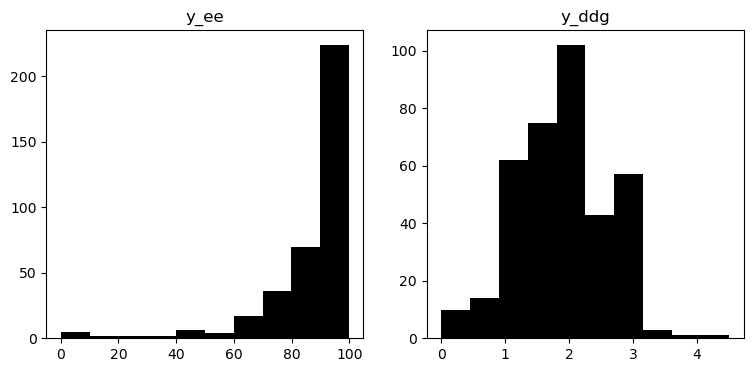

          min,  mean,   max, stdev
y_ee      0.0,  86.1,  99.9,  17.1
y_ddg    0.00,  1.88,  4.50,  0.73
0
LassoCV time: 5 sec
GaussianProcess_CV time: 7 sec
GradientBoostingRegressor_CV_rs time: 8 sec
RandomForestRegressor_CV_rs time: 21 sec
ExtraTreesRegressor_CV_rs time: 21 sec
LassoCV time: 7 sec
GaussianProcess_CV time: 5 sec
GradientBoostingRegressor_CV_rs time: 8 sec
RandomForestRegressor_CV_rs time: 22 sec
ExtraTreesRegressor_CV_rs time: 18 sec
1
GaussianProcess_CV time: 7 sec
GradientBoostingRegressor_CV_rs time: 9 sec
RandomForestRegressor_CV_rs time: 21 sec
ExtraTreesRegressor_CV_rs time: 23 sec
GaussianProcess_CV time: 5 sec
GradientBoostingRegressor_CV_rs time: 8 sec
RandomForestRegressor_CV_rs time: 22 sec
ExtraTreesRegressor_CV_rs time: 19 sec


ee                           \
                                  R2_train       R2_test RMSE_train   
LinearRegression                      0.74 -2.631115e+25       8.79   
RidgeCV                               0.65  2.400000e-01      10.13   
LassoCV                               0.63  2.500000e-01      10.53   
LarsCV                                0.26  2.300000e-01      14.81   
LassoLarsCV                           0.61  2.400000e-01      10.68   
ElasticNetCV                          0.60  2.800000e-01      10.83   
KernelRidge_poly_CV                   0.64  2.700000e-01      10.35   
KernelRidge_rbf_CV                    0.66 -1.900000e-01      10.05   
GaussianProcess_CV                    0.66  2.300000e-01       9.98   
GradientBoostingRegressor_CV_hrs0     0.63  2.600000e-01      10.47   
GradientBoostingRegressor_CV_hrs1     0.82 -9.000000e-02       7.25   
GradientBoostingRegressor_CV_hrs2     0.66  2.100000e-01       9.97   
GradientBoostingRegressor_CV_rs       0.64  1.400000e-01      10.26   
RandomForestRegressor_CV_hrs0         0.67  9.000000e-02       9.82   
RandomForestRegressor_CV_rs           0.61  3.100000e-01      10.70   
ExtraTreesRegressor_CV_rs             0.65  2.600000e-01      10.10   
ExtraTreesRegressor_CV_hrs2           0.44 -5.000000e-02      12.13   
KNeighborsRegressor                   0.50 -1.100000e-01      11.95   

                                                                         \
                                      RMSE_test MAE_train      MAE_test   
LinearRegression                   6.953028e+13      4.02  2.367263e+13   
RidgeCV                            1.429000e+01      5.80  8.970000e+00   
LassoCV                            1.417000e+01      6.50  8.640000e+00   
LarsCV                             1.447000e+01     10.40  1.013000e+01   
LassoLarsCV                        1.426000e+01      6.65  8.670000e+00   
ElasticNetCV                       1.388000e+01      6.75  8.830000e+00   
KernelRidge_poly_CV                1.402000e+01      6.06  8.950000e+00   
KernelRidge_rbf_CV                 1.783000e+01      6.27  1.181000e+01   
GaussianProcess_CV                 1.431000e+01      5.72  8.850000e+00   
GradientBoostingRegressor_CV_hrs0  1.383000e+01      6.67  8.160000e+00   
GradientBoostingRegressor_CV_hrs1  1.675000e+01      2.42  8.690000e+00   
GradientBoostingRegressor_CV_hrs2  1.440000e+01      6.35  8.520000e+00   
GradientBoostingRegressor_CV_rs    1.501000e+01      6.28  8.530000e+00   
RandomForestRegressor_CV_hrs0      1.531000e+01      5.86  8.620000e+00   
RandomForestRegressor_CV_rs        1.357000e+01      6.31  8.100000e+00   
ExtraTreesRegressor_CV_rs          1.397000e+01      5.73  8.060000e+00   
ExtraTreesRegressor_CV_hrs2        1.679000e+01      7.28  9.800000e+00   
KNeighborsRegressor                1.695000e+01      7.26  9.620000e+00   

                                                               ee2ddg          \
                                  MAErel_train   MAErel_test R2_train R2_test   
LinearRegression                          0.24  1.384981e+12     0.10  -33.38   
RidgeCV                                   0.34  5.200000e-01     0.41   -0.15   
LassoCV                                   0.38  5.100000e-01     0.44    0.11   
LarsCV                                    0.61  5.900000e-01    -0.06   -0.18   
LassoLarsCV                               0.39  5.100000e-01     0.41    0.10   
ElasticNetCV                              0.39  5.200000e-01     0.41    0.07   
KernelRidge_poly_CV                       0.35  5.200000e-01     0.47    0.06   
KernelRidge_rbf_CV                        0.37  6.900000e-01     0.18   -1.32   
GaussianProcess_CV                        0.33  5.200000e-01     0.52    0.07   
GradientBoostingRegressor_CV_hrs0         0.39  4.800000e-01     0.41    0.14   
GradientBoostingRegressor_CV_hrs1         0.14  5.100000e-01     0.76   -0.30   
GradientBoostingRegressor_CV_hrs2         0.37  5.000000e-01     

In [139]:
for dataset in settings.keys():  
    if dataset in datasets.keys():
        continue

    print("\n","-"*100,"\n","-"*100,"\n",dataset)
    
    filefolder = settings[dataset]["filefolder"]
    filename = settings[dataset]["filename"]
    y_column = settings[dataset]["y_column"]
    origdomain = settings[dataset]["origdomain"]    
    features = settings[dataset]["features"]
    
#     if filename.split(".")[-1] == "xlsx":
#         sheet_name = settings[dataset]["sheet_name"]
#         df = pd.read_excel(filefolder+filename,index_col=0,sheet_name=sheet_name)
    if filename.split(".")[-1] == "csv":
        df = pd.read_csv(filefolder+filename,sep=sep)

    if type(settings[dataset]["T"]) == int:
        T_vect = pd.Series(np.ones(df.shape[0]) * settings[dataset]["T"],index=df.index,dtype=float)
        
    elif type(settings[dataset]["T"]) == str:
        T_vect = df[settings[dataset]["T"]]
        
    if origdomain == "ddg":
        y_ddg = df[y_column]
        y_ee = g2ee(y_ddg,T_vect)

    elif origdomain == "ee":
        y_ee = df[y_column]
        y_ddg = ee2g(y_ee,T_vect)

    cols = df.columns
    indices = df.index
    
    if features == "descriptors":
        usecolumns = settings[dataset]["usecolumns"]
        X = np.asarray(df[cols[usecolumns[0]:usecolumns[1]]])
    elif features == "fingerprint":
        smi_column = settings[dataset]["smi_column"]
        X = np.asarray([smi_fp(sm,fp_size) for sm in df[smi_column]])

    if verbose_min:
        print(y_ee.shape)
        print(y_ddg.shape)
        print(X.shape)

        plt.figure(figsize=(9,4))
        plt.subplot(1,2,1)
        plt.hist(y_ee, color="black")
        plt.title("y_ee")

        plt.subplot(1,2,2)
        plt.hist(y_ddg, color="black")
        plt.title("y_ddg")
        plt.show()

        print(f"{'min':>13},{'mean':>6},{'max':>6},{'stdev':>6}")
        print(f"{'y_ee':<6} {y_ee.min():>6.1f},{y_ee.mean():>6.1f},{y_ee.max():>6.1f},{y_ee.std():>6.1f}")
        print(f"{'y_ddg':<6} {y_ddg.min():>6.2f},{y_ddg.mean():>6.2f},{y_ddg.max():>6.2f},{y_ddg.std():>6.2f}")
        # print(f"y_ddg,y_ddg.min().round(2),y_ddg.mean().round(2),y_ddg.max().round(2),y_ddg.std().round(2)")


    ys = {"ee":y_ee,
          "ddg":y_ddg}
    domains = ["ee","ee2ddg","ddg"]
    scores = ["R2_train","R2_test","RMSE_train","RMSE_test","MAE_train","MAE_test","MAErel_train","MAErel_test"]
    
    all_model_results = {}
    for i in itertools.product(models.keys(),itertools.product(domains,scores)):
        all_model_results[i] = pd.Series(index=range(num_trials), dtype=float)
    
    for random_state in range(num_trials):
        if verbose_min: print(random_state)
        train_idx,test_idx = train_test_split(range(len(indices)),test_size = test_size, random_state = random_state)

        model_results = pd.DataFrame(
            columns = pd.MultiIndex.from_product((domains,scores)),
            dtype=float)
        
        for domain in ["ee","ddg"]:
            y = ys[domain]

#             X_train, y_train, T_train = X.loc[train_idx], y.loc[train_idx], T_vect[train_idx]
#             X_test, y_test, T_test = X.loc[test_idx], y.loc[test_idx], T_vect[test_idx]

            X_train, y_train, T_train = X[train_idx], y[train_idx], T_vect[train_idx]
            X_test, y_test, T_test = X[test_idx], y[test_idx], T_vect[test_idx]

            # perform feature scaling
            scaler = StandardScaler() 
            # scaler = RobustScaler()
            # scaler = RobustScaler(quantile_range=(5.0, 95.0)) 
            # scaler = MinMaxScaler()

            scaler.fit(X_train)
            X_train = scaler.transform(X_train)
            X_test  = scaler.transform(X_test)
            
            if verbose:
                print("-"*50,"\n",domain,"\n")
                print(f"Range of target values: {y.min():.2f} to {y.max():.2f} (Delta = {y.max()-y.min():.2f})")
                print(f"Target standard deviation: {y.std():.2f}\n")

                # visualize target distribution across the sets
                plt.figure(figsize=(5,5))
                _, bins, _ = plt.hist(y_train,alpha=0.5,label="training",color="black")
                plt.hist(y_test,alpha=0.5,label="test",color="blue", bins=bins)
                plt.xlabel("Selectivity")
                plt.ylabel("number of samples, N")
                plt.legend()
                plt.show()

                print(f"size of \ntraining set: {X_train.shape[0]:6.0f} = {X_train.shape[0]/X.shape[0]*100:.0f}%\ntest set: {X_test.shape[0]:10.0f} = {X_test.shape[0]/X.shape[0]*100:.0f}%\n")
                print(f"mean and variance of \ntraining set: {y_train.mean():6.2f}   {y_train.var():.2f}\ntest set: {y_test.mean():10.2f}   {y_test.var():.2f}\n")

            # fit each model
            for modelname,model in models.items():
                try:
                    results = run_model(X_train,X_test,y_train,y_test,T_train,T_test,modelname,model,domain=domain,verbose=verbose)
                    model_results.loc[modelname,results.keys()] = results
                    for sc in results.keys():
                        all_model_results[(modelname,sc)][random_state] = results[sc]
                except ValueError:
                    print(f"{modelname} failed")
                    pass

#         datasets[dataset] = model_results
#         model_results.to_csv(dataset+"_model_results.csv",sep=";")
#         model_results.round(2)

    with open(f"{dataset}_{date.today().isoformat()}_all_model_results","wb") as f:
        pickle.dump(all_model_results,f)

    fin_model_results = pd.DataFrame(
        columns = pd.MultiIndex.from_product((domains,scores)),
        index = model_results.index,
        dtype=float)
    
    for (modelname,(domain,score)),result_series in all_model_results.items():
        #all_model_results[i]# = pd.Series(index=range(num_trials))
        
        fin_model_results.loc[modelname,(domain,score)] = result_series.mean()
        fin_model_results.loc[modelname,(domain,score+"_std")] = result_series.std()
        
    datasets[dataset] = fin_model_results
    fin_model_results.to_csv(f"{dataset}_{date.today().isoformat()}_fin_model_results.csv",sep=";")
    if verbose_min:
        display(fin_model_results.round(2))
    
with open(f"datasets_{date.today().isoformat()}.p","wb") as f:
    pickle.dump(datasets,f)

In [47]:
# optionally re-read results from individual csvs
for dataset in settings.keys():
    fin_model_results = pd.read_csv(dataset+"fin_model_results.csv",sep=";",index_col=0,header=[0,1])
    datasets[dataset] = fin_model_results

In [41]:
# optionally restore results
with open(f"datasets_2023-04-17.p","rb") as f:
    datasets = pickle.load(f)

In [53]:
for dataset,df in datasets.items():
    print(dataset)
    show_ind = [m for m in df.index if df.loc[m].max() < 1000] # skip models with extremely bad performance for prettier formatting
    display(df.loc[show_ind,show].sort_values(by=("ddg","RMSE_test")).round(2))

Sunoj_DD_2_FP


ee            ee2ddg               ddg          
                    R2_test RMSE_test R2_test RMSE_test R2_test RMSE_test
LassoCV                0.89      9.01    0.50      0.44    0.84      0.25
RidgeCV                0.89      9.01    0.43      0.47    0.84      0.25
ElasticNetCV           0.89      9.04    0.51      0.44    0.84      0.25
LinearRegression       0.90      8.93    0.33      0.49    0.84      0.25
LassoLarsCV            0.88      9.61    0.58      0.39    0.84      0.26
KNeighborsRegressor    0.81     12.20    0.75      0.32    0.75      0.32
LarsCV                 0.11     26.17    0.06      0.62    0.66      0.37

Sunoj_DD_3_FP


ee            ee2ddg               ddg          
                    R2_test RMSE_test R2_test RMSE_test R2_test RMSE_test
LassoLarsCV            0.24     14.26    0.10      0.65    0.37      0.55
LassoCV                0.25     14.17    0.11      0.65    0.35      0.55
ElasticNetCV           0.28     13.88    0.07      0.66    0.34      0.56
RidgeCV                0.24     14.29   -0.15      0.73    0.31      0.57
KNeighborsRegressor   -0.11     16.95    0.01      0.69    0.17      0.62
LarsCV                 0.23     14.47   -0.18      0.75    0.13      0.64

Denmark_OPRD_FP


ee            ee2ddg               ddg          
                    R2_test RMSE_test R2_test RMSE_test R2_test RMSE_test
RidgeCV                0.67     11.93    0.68      0.18    0.67      0.18
LassoCV                0.66     12.01    0.68      0.18    0.66      0.18
ElasticNetCV           0.66     11.98    0.67      0.18    0.65      0.18
LassoLarsCV            0.65     12.25    0.65      0.18    0.64      0.19
KNeighborsRegressor    0.32     16.99    0.36      0.25    0.33      0.25
LarsCV                 0.39     16.32    0.36      0.25     NaN       NaN

Toste_Desc


ee            ee2ddg               ddg          
                    R2_test RMSE_test R2_test RMSE_test R2_test RMSE_test
KNeighborsRegressor    0.58     13.51    0.62      0.24    0.53      0.26
LassoLarsCV            0.59     13.98    0.51      0.27    0.52      0.27
LassoCV                0.58     14.03    0.51      0.27    0.51      0.27
LarsCV                 0.38     16.72    0.35      0.31    0.37      0.30
RidgeCV                0.56     14.61    0.46      0.29    0.39      0.31
ElasticNetCV           0.62     13.65    0.55      0.26    0.34      0.32
LinearRegression    -206.22    194.11 -231.61      4.96 -121.03      3.40

Biscoe_Desc


ee            ee2ddg               ddg          
                    R2_test RMSE_test R2_test RMSE_test R2_test RMSE_test
LinearRegression       0.36     24.95   -3.87      1.52    0.74      0.46
RidgeCV                0.08     26.94  -10.27      2.17    0.68      0.51
ElasticNetCV           0.06     27.30  -10.36      2.19    0.64      0.55
KNeighborsRegressor    0.23     31.29    0.49      0.58    0.49      0.58
LassoCV                0.01     27.86  -14.90      2.56    0.53      0.62
LassoLarsCV            0.02     27.60  -14.92      2.58    0.44      0.67
LarsCV                 0.36     28.09    0.56      0.60    0.21      0.80

Doyle_Desc


ee            ee2ddg               ddg          
                    R2_test RMSE_test R2_test RMSE_test R2_test RMSE_test
KNeighborsRegressor    0.67      7.22    0.54      0.24    0.54      0.24
LarsCV                 0.50      8.95    0.41      0.27    0.53      0.24
LassoCV               -0.59     14.38  -15.74      1.11    0.53      0.24
LassoLarsCV           -0.59     14.36  -15.74      1.11    0.53      0.24
ElasticNetCV          -0.70     14.95  -15.94      1.15   -0.11      0.37
RidgeCV               -0.51     14.29  -15.95      1.16   -0.35      0.40
LinearRegression     -23.44     56.96  -44.73      2.41  -20.08      1.46

Sunoj_Desc


ee            ee2ddg               ddg          
                    R2_test RMSE_test R2_test RMSE_test R2_test RMSE_test
KNeighborsRegressor   -0.02     12.43   -0.18      0.69    0.11      0.59
LassoLarsCV            0.05     12.03   -0.24      0.71    0.08      0.61
LassoCV                0.05     12.03   -0.24      0.71    0.08      0.61
ElasticNetCV           0.06     12.02   -0.24      0.71    0.08      0.61
RidgeCV                0.07     11.93   -0.23      0.70    0.06      0.62

Sunoj_JPC_Desc


ee            ee2ddg               ddg          
                    R2_test RMSE_test R2_test RMSE_test R2_test RMSE_test
ElasticNetCV           0.16     10.51   -0.47      0.61    0.35      0.41
KNeighborsRegressor    0.29      9.67    0.36      0.41    0.34      0.41
LarsCV                 0.14     10.64   -0.03      0.52    0.33      0.41
LassoCV                0.05     11.25   -1.49      0.80    0.33      0.41
LassoLarsCV            0.05     11.23   -1.48      0.80    0.33      0.41
RidgeCV                0.11     10.79   -1.74      0.82    0.32      0.42

HongAckermann_Desc


ee            ee2ddg               ddg          
                    R2_test RMSE_test R2_test RMSE_test R2_test RMSE_test
ElasticNetCV           0.73     11.89    0.64      0.59    0.77      0.47
RidgeCV                0.74     11.88    0.35      0.78    0.76      0.47
LassoCV                0.71     12.44    0.52      0.67    0.76      0.48
LassoLarsCV            0.71     12.47    0.52      0.67    0.76      0.48
KNeighborsRegressor    0.86      8.77    0.68      0.55    0.72      0.52
LinearRegression       0.72     12.08   -0.07      1.01    0.63      0.59
LarsCV                 0.54     15.83   -0.13      1.00    0.19      0.88

Denmark_OPRD_Desc


ee            ee2ddg               ddg          
                    R2_test RMSE_test R2_test RMSE_test R2_test RMSE_test
RidgeCV                0.69     11.44    0.68      0.18    0.69      0.17
ElasticNetCV           0.69     11.53    0.69      0.17    0.69      0.17
LassoCV                0.68     11.60    0.68      0.18    0.69      0.17
LassoLarsCV            0.69     11.51    0.69      0.17    0.67      0.18
KNeighborsRegressor    0.61     12.77    0.64      0.19    0.63      0.19
LarsCV                 0.26     17.44    0.23      0.27    0.28      0.26

# Skew scores

In [54]:
skew_scores = {}


 ---------------------------------------------------------------------------------------------------- 
 ---------------------------------------------------------------------------------------------------- 
 Toste_Desc
y size: (37,)
Skew ee/ddG: -0.15 0.40


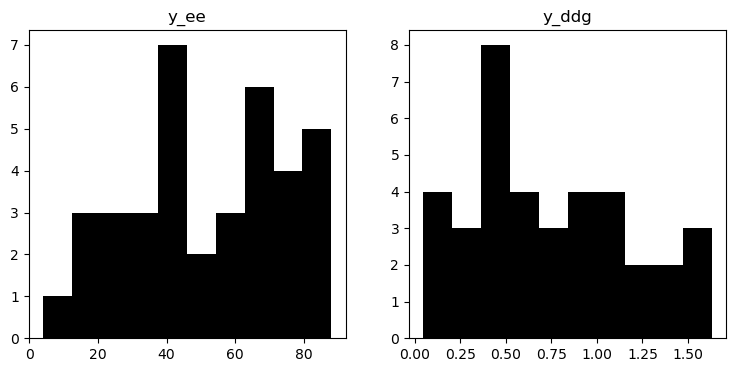

          min,  mean,   max, stdev
y_ee      4.0,  51.3,  88.0,  24.0
y_ddg    0.05,  0.75,  1.63,  0.44

 ---------------------------------------------------------------------------------------------------- 
 ---------------------------------------------------------------------------------------------------- 
 Biscoe_Desc
y size: (24,)
Skew ee/ddG: -0.67 0.35


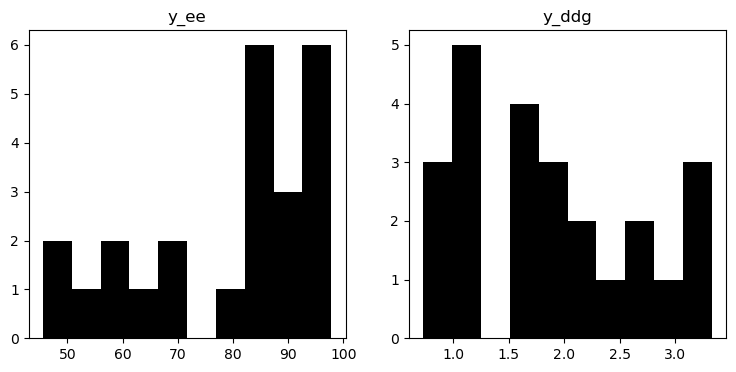

          min,  mean,   max, stdev
y_ee    -89.7,  62.2,  97.8,  52.3
y_ddg   -2.16,  1.54,  3.33,  1.36

 ---------------------------------------------------------------------------------------------------- 
 ---------------------------------------------------------------------------------------------------- 
 Doyle_Desc
y size: (29,)
Skew ee/ddG: -0.01 0.28


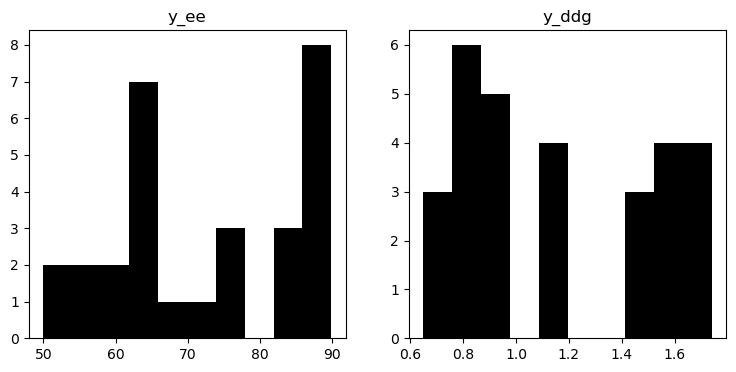

          min,  mean,   max, stdev
y_ee     49.9,  72.4,  89.9,  13.3
y_ddg    0.65,  1.16,  1.74,  0.37

 ---------------------------------------------------------------------------------------------------- 
 ---------------------------------------------------------------------------------------------------- 
 Sunoj_Desc
y size: (371,)
Skew ee/ddG: -3.24 -0.04


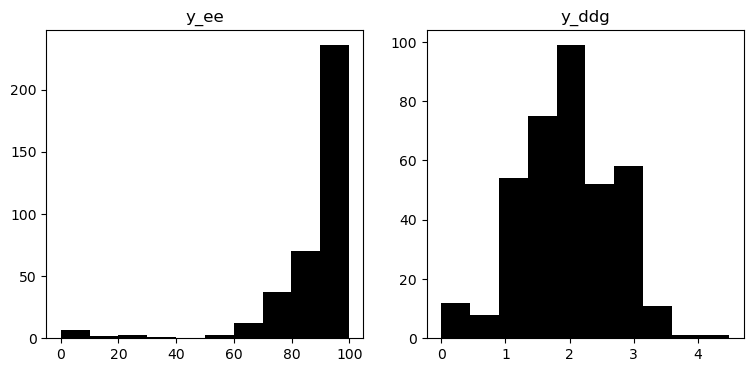

          min,  mean,   max, stdev
y_ee      0.0,  87.1,  99.9,  17.1
y_ddg    0.00,  1.97,  4.49,  0.74

 ---------------------------------------------------------------------------------------------------- 
 ---------------------------------------------------------------------------------------------------- 
 Sunoj_JPC_Desc
y size: (398,)
Skew ee/ddG: -3.54 -0.39


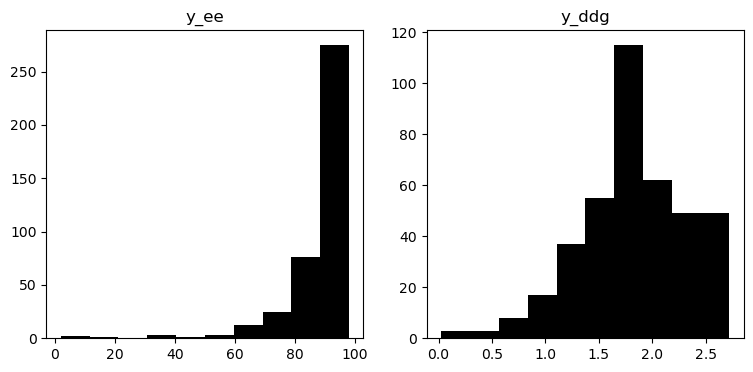

          min,  mean,   max, stdev
y_ee      2.0,  88.4,  98.0,  12.1
y_ddg    0.02,  1.85,  2.72,  0.52

 ---------------------------------------------------------------------------------------------------- 
 ---------------------------------------------------------------------------------------------------- 
 HongAckermann_Desc
y size: (127,)
Skew ee/ddG: -1.49 -0.54


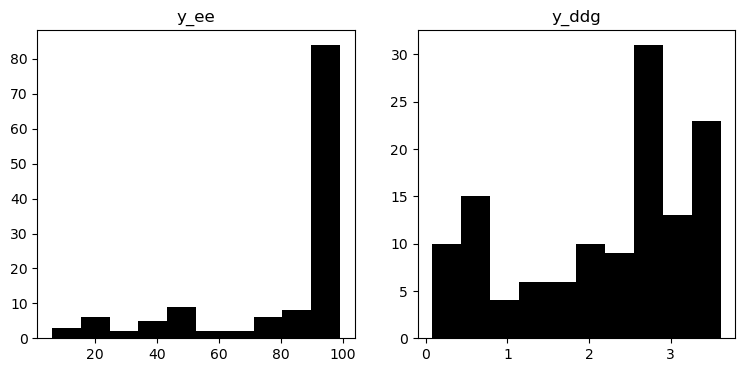

          min,  mean,   max, stdev
y_ee      6.0,  81.5,  99.0,  26.0
y_ddg    0.08,  2.20,  3.61,  1.07

 ---------------------------------------------------------------------------------------------------- 
 ---------------------------------------------------------------------------------------------------- 
 Denmark_OPRD_Desc
y size: (471,)
Skew ee/ddG: -1.05 -0.60


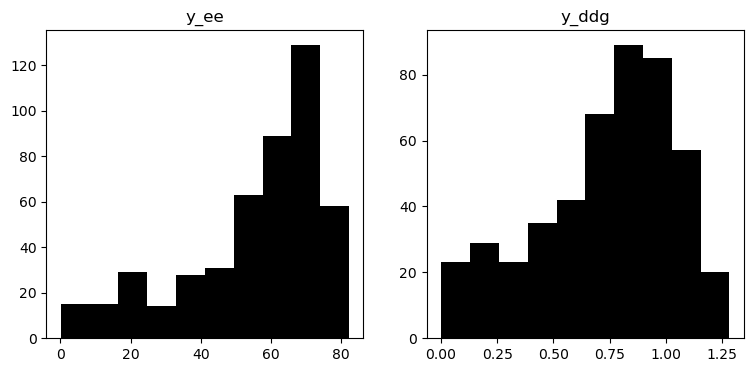

          min,  mean,   max, stdev
y_ee    -17.0,  55.2,  82.3,  20.6
y_ddg   -0.19,  0.73,  1.28,  0.31

 ---------------------------------------------------------------------------------------------------- 
 ---------------------------------------------------------------------------------------------------- 
 Sunoj_DD_2_FP
y size: (1027,)
Skew ee/ddG: -0.63 0.86


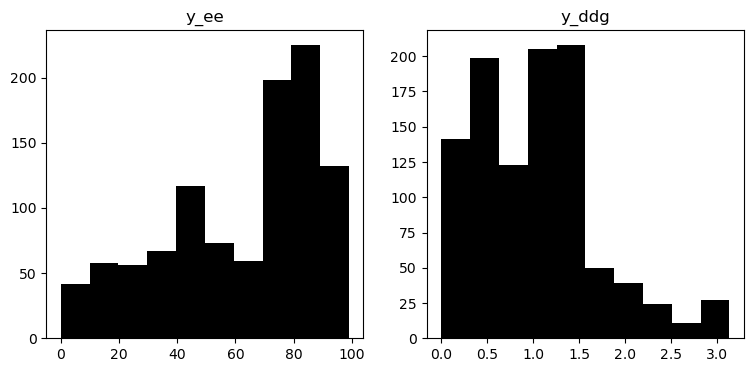

          min,  mean,   max, stdev
y_ee      0.0,  61.4,  99.0,  27.0
y_ddg    0.00,  1.04,  3.14,  0.67

 ---------------------------------------------------------------------------------------------------- 
 ---------------------------------------------------------------------------------------------------- 
 Sunoj_DD_3_FP
y size: (368,)
Skew ee/ddG: -2.79 0.03


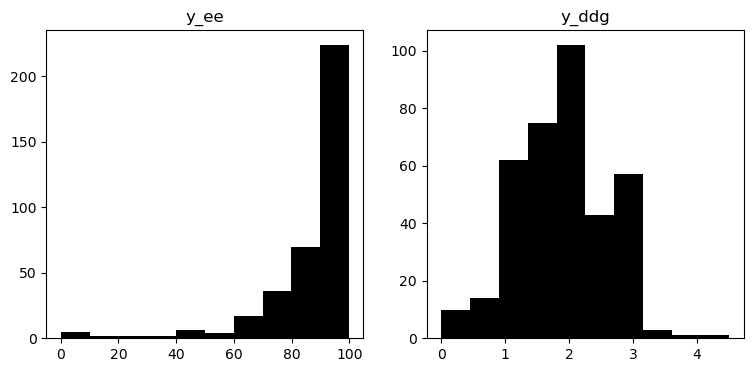

          min,  mean,   max, stdev
y_ee      0.0,  86.1,  99.9,  17.1
y_ddg    0.00,  1.88,  4.50,  0.73

 ---------------------------------------------------------------------------------------------------- 
 ---------------------------------------------------------------------------------------------------- 
 Denmark_OPRD_FP
y size: (471,)
Skew ee/ddG: -1.05 -0.60


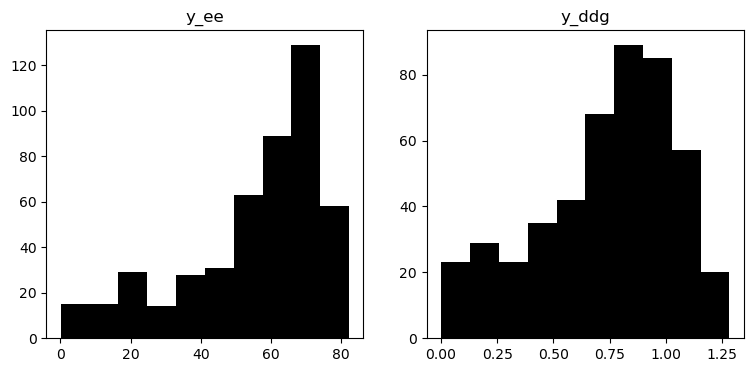

          min,  mean,   max, stdev
y_ee    -17.0,  55.2,  82.3,  20.6
y_ddg   -0.19,  0.73,  1.28,  0.31


In [94]:
raw_data = {}
y_ee_all = {}
y_ddg_all = {}
for dataset in settings.keys():
    print("\n","-"*100,"\n","-"*100,"\n",dataset)
    
    filefolder = settings[dataset]["filefolder"]
    filename = settings[dataset]["filename"]
    y_column = settings[dataset]["y_column"]
    origdomain = settings[dataset]["origdomain"]    
    
#     if filename.split(".")[-1] == "xlsx":
#         sheet_name = settings[dataset]["sheet_name"]
#         df = pd.read_excel(filefolder+filename,index_col=0,sheet_name=sheet_name)
    if filename.split(".")[-1] == "csv":
#         sep = settings[dataset]["sep"]
        df = pd.read_csv(filefolder+filename,index_col=0,sep=sep)

    if type(settings[dataset]["T"]) == int:
        T_vect = pd.Series(np.ones(df.shape[0]) * settings[dataset]["T"],index=df.index)
#         T_vect = np.ones(df.shape[0]) * settings[dataset]["T"]
        
    elif type(settings[dataset]["T"]) == str:
        T_vect = df[settings[dataset]["T"]]
        
    if origdomain == "ddg":
        y_ddg = df[y_column]
        y_ee = g2ee(y_ddg,T_vect)

    elif origdomain == "ee":
        y_ee = df[y_column]
        y_ddg = ee2g(y_ee,T_vect)

    cols = df.columns
    indices = df.index

    raw_data[dataset] = df
    y_ee_all[dataset] = y_ee
    y_ddg_all[dataset] = y_ddg
    skew_scores[dataset] = (skew(np.abs(y_ee)),skew(np.abs(y_ddg)))    

    print(f"y size: {y_ee.shape}")        
    print(f"Skew ee/ddG: {skew(np.abs(y_ee)):.2f} {skew(np.abs(y_ddg)):.2f}")

    plt.figure(figsize=(9,4))
    plt.subplot(1,2,1)
    plt.hist(np.abs(y_ee), color="black")
    plt.title("y_ee")
    # plt.show()

    plt.subplot(1,2,2)
    plt.hist(np.abs(y_ddg), color="black")
    plt.title("y_ddg")
    plt.show()

    print(f"{'min':>13},{'mean':>6},{'max':>6},{'stdev':>6}")
    print(f"{'y_ee':<6} {y_ee.min():>6.1f},{y_ee.mean():>6.1f},{y_ee.max():>6.1f},{y_ee.std():>6.1f}")
    print(f"{'y_ddg':<6} {y_ddg.min():>6.2f},{y_ddg.mean():>6.2f},{y_ddg.max():>6.2f},{y_ddg.std():>6.2f}")
    # print(f"y_ddg,y_ddg.min().round(2),y_ddg.mean().round(2),y_ddg.max().round(2),y_ddg.std().round(2)")

        

In [95]:

df = pd.DataFrame.from_dict(skew_scores,orient="index", columns = ["y_ee","y_ddg"])
#display(df.round(2))

print("average skew y_ee ",df["y_ee"].mean().round(2))
print("average skew y_ddg",df["y_ddg"].mean().round(2))


df["diff"] = abs(df["y_ee"] - df["y_ddg"])
for dataset in df.index:
    df.loc[dataset,"N"] = raw_data[dataset].shape[0]
df["N"] = df["N"].astype(int)
display(df.sort_values(by="diff").round(2))

average skew y_ee  -1.46
average skew y_ddg -0.02


,y_ee,y_ddg,diff,N
Doyle_Desc,-0.01,0.28,0.29,29
Denmark_OPRD_Desc,-1.05,-0.60,0.44,471
Denmark_OPRD_FP,-1.05,-0.60,0.44,471
Toste_Desc,-0.15,0.40,0.55,37
HongAckermann_Desc,-1.49,-0.54,0.96,127
Biscoe_Desc,-0.67,0.35,1.02,24
Sunoj_DD_2_FP,-0.63,0.86,1.49,1027
Sunoj_DD_3_FP,-2.79,0.03,2.82,368
Sunoj_JPC_Desc,-3.54,-0.39,3.15,398
Sunoj_Desc,-3.24,-0.04,3.20,371


y size: (1457,)
Skew ee/ddG: -1.25 0.38


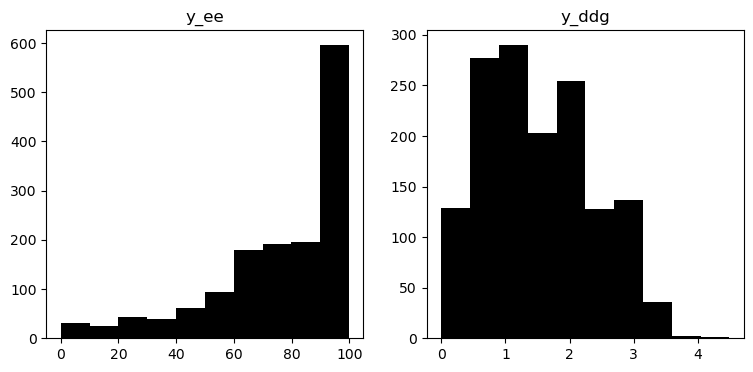

In [92]:
y_ee_combine = pd.concat([y_ee_all[k] for k in y_ee_all.keys() if "_Desc" in k])
y_ddg_combine = pd.concat([y_ddg_all[k] for k in y_ee_all.keys() if "_Desc" in k])

print(f"y size: {y_ee_combine.shape}")        
print(f"Skew ee/ddG: {skew(np.abs(y_ee_combine)):.2f} {skew(np.abs(y_ddg_combine)):.2f}")

plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.hist(np.abs(y_ee_combine), color="black",bins=10)
plt.title("y_ee")
# plt.show()

plt.subplot(1,2,2)
plt.hist(np.abs(y_ddg_combine), color="black",bins=10)
plt.title("y_ddg")
plt.show()

# Aggregate modeling results

In [88]:
with open("datasets_23_04_12.p","rb") as f:
    datasets = pickle.load(f)

In [151]:
overview = pd.DataFrame(
        columns = pd.MultiIndex.from_product((["ee","ee2ddg","ddg"],["Model","R2_test","RMSE_test","MAErel_test"])),)

In [152]:
for dataset,df in datasets.items():
    print(dataset)
    for domain in ["ee","ee2ddg","ddg"]:
        top = df.idxmin()        
        topmodel = top[(domain,"MAErel_test")]
        overview.loc[dataset,(domain,"Model")] = topmodel
        overview.loc[dataset,(domain,"R2_test")] = df.loc[topmodel,(domain,"R2_test")]
        overview.loc[dataset,(domain,"RMSE_test")] = df.loc[topmodel,(domain,"RMSE_test")]
        overview.loc[dataset,(domain,"MAErel_test")] = df.loc[topmodel,(domain,"MAErel_test")]
        

Toste_Desc
Biscoe_Desc
Doyle_Desc
Sunoj_DD_3_FP


In [92]:
overview

ee                       \
                                                Model   R2_test  RMSE_test   
Sunoj_DD_3_FP                            ElasticNetCV  0.426861  13.267378   
Sunoj_DD_2_FP         GradientBoostingRegressor_CV_rs  0.949398   6.274202   
Denmark_OPRD_FP       GradientBoostingRegressor_CV_rs  0.667353  11.829671   
Toste_desc                        KernelRidge_poly_CV    0.6721  14.070099   
Biscoe_desc         GradientBoostingRegressor_CV_hrs2  0.461047  14.174057   
Sunoj_desc                  ExtraTreesRegressor_CV_rs  0.124873  16.094713   
HongAckermann_desc  GradientBoostingRegressor_CV_hrs2  0.774326   9.761245   
Sunoj_JPC_desc                    KernelRidge_poly_CV  0.714382   6.818052   
Denmark_OPRD_desc   GradientBoostingRegressor_CV_hrs1  0.717082  10.909656   

                                               ee2ddg                      \
                                                Model   R2_test RMSE_test   
Sunoj_DD_3_FP               ExtraTreesRegressor_CV_rs  0.466405  0.512668   
Sunoj_DD_2_FP       GradientBoostingRegressor_CV_hrs2  0.920123  0.199768   
Denmark_OPRD_FP       GradientBoostingRegressor_CV_rs  0.690962  0.169679   
Toste_desc                        KernelRidge_poly_CV  0.679613  0.214737   
Biscoe_desc                       KernelRidge_poly_CV  0.490594  0.761834   
Sunoj_desc          GradientBoostingRegressor_CV_hrs2 -0.073698  0.755097   
HongAckermann_desc  GradientBoostingRegressor_CV_hrs2  0.630685  0.532373   
Sunoj_JPC_desc              ExtraTreesRegressor_CV_rs  0.651651  0.282768   
Denmark_OPRD_desc         RandomForestRegressor_CV_rs  0.727717   0.15927   

                                                  ddg                      
                                                Model   R2_test RMSE_test  
Sunoj_DD_3_FP             RandomForestRegressor_CV_rs  0.469045  0.511398  
Sunoj_DD_2_FP         GradientBoostingRegressor_CV_rs  0.931651  0.184792  
Denmark_OPRD_FP     GradientBoostingRegressor_CV_hrs2  0.690296  0.169862  
Toste_desc                         GaussianProcess_CV  0.671405   0.21747  
Biscoe_desc                                   LassoCV  0.938814  0.264032  
Sunoj_desc            GradientBoostingRegressor_CV_rs  0.333039  0.595131  
HongAckermann_desc          ExtraTreesRegressor_CV_rs  0.830299  0.360877  
Sunoj_JPC_desc                    KernelRidge_poly_CV  0.597843  0.303823  
Denmark_OPRD_desc           ExtraTreesRegressor_CV_rs  0.709566  0.164493

In [93]:
with open("overview_23_04_14.p","wb") as f:
    pickle.dump(overview,f)

In [177]:
linearmodels = ["LinearRegression","RidgeCV","LassoCV","LarsCV","LassoLarsCV","ElasticNetCV",]
othermodels = [i for i in models.keys() if i not in linearmodels]

overview_sets = pd.DataFrame(
        columns = pd.MultiIndex.from_product((["ee","ee2ddg","ddg"],["Model","R2_test","RMSE_test","MAErel_test"])),)
overview_sep["set"] = []
for dataset,df in datasets.items():
    if "_Desc" in dataset: 
        for domain in ["ee","ee2ddg","ddg"]:
            #linear models
            top = df.loc[linearmodels].idxmin()        
            topmodel = top[(domain,"MAErel_test")]
            overview_sets.loc[dataset+"_desc_linear",(domain,"Model")] = topmodel
            overview_sets.loc[dataset+"_desc_linear","set"] = "desc_linear"            
            overview_sets.loc[dataset+"_desc_linear",(domain,"R2_test")] = df.loc[topmodel,(domain,"R2_test")]
            overview_sets.loc[dataset+"_desc_linear",(domain,"RMSE_test")] = df.loc[topmodel,(domain,"RMSE_test")]
            overview_sets.loc[dataset+"_desc_linear",(domain,"MAErel_test")] = df.loc[topmodel,(domain,"MAErel_test")]
            
            #other models
            top = df.loc[othermodels].idxmin()        
            topmodel = top[(domain,"MAErel_test")]
            overview_sets.loc[dataset+"_desc_other",(domain,"Model")] = topmodel
            overview_sets.loc[dataset+"_desc_other","set"] = "desc_other"
            overview_sets.loc[dataset+"_desc_other",(domain,"R2_test")] = df.loc[topmodel,(domain,"R2_test")]
            overview_sets.loc[dataset+"_desc_other",(domain,"RMSE_test")] = df.loc[topmodel,(domain,"RMSE_test")]
            overview_sets.loc[dataset+"_desc_other",(domain,"MAErel_test")] = df.loc[topmodel,(domain,"MAErel_test")]
            
    if "_FP" in dataset: 
        for domain in ["ee","ee2ddg","ddg"]:
            top = df.idxmin()        
            topmodel = top[(domain,"MAErel_test")]
            overview_sets.loc[dataset+"_fp_all",(domain,"Model")] = topmodel
            overview_sets.loc[dataset+"_fp_all","set"] = "fp_all"
            overview_sets.loc[dataset+"_fp_all",(domain,"R2_test")] = df.loc[topmodel,(domain,"R2_test")]
            overview_sets.loc[dataset+"_fp_all",(domain,"RMSE_test")] = df.loc[topmodel,(domain,"RMSE_test")]
            overview_sets.loc[dataset+"_fp_all",(domain,"MAErel_test")] = df.loc[topmodel,(domain,"MAErel_test")]

display(overview_sets)

ee                       \
                                             Model   R2_test  RMSE_test   
Toste_Desc_desc_linear                ElasticNetCV   0.61671  13.648965   
Toste_Desc_desc_other           GaussianProcess_CV  0.662196  12.961174   
Biscoe_Desc_desc_linear                     LarsCV  0.357872   28.08653   
Biscoe_Desc_desc_other         KernelRidge_poly_CV  0.462883  23.572987   
Doyle_Desc_desc_linear                      LarsCV  0.504243   8.946251   
Doyle_Desc_desc_other    ExtraTreesRegressor_CV_rs  0.679707   7.208235   
Sunoj_DD_3_FP_fp_all     ExtraTreesRegressor_CV_rs   0.25572  13.970194   

                                                        ee2ddg            \
                        MAErel_test                      Model   R2_test   
Toste_Desc_desc_linear     0.486241               ElasticNetCV  0.554809   
Toste_Desc_desc_other      0.438059         GaussianProcess_CV  0.650635   
Biscoe_Desc_desc_linear    0.326159                     LarsCV  0.555253   
Biscoe_Desc_desc_other     0.342175        KNeighborsRegressor  0.491638   
Doyle_Desc_desc_linear     0.551908                     LarsCV  0.405356   
Doyle_Desc_desc_other      0.435713  ExtraTreesRegressor_CV_rs  0.649105   
Sunoj_DD_3_FP_fp_all       0.471829  ExtraTreesRegressor_CV_rs  0.210273   

                                               \
                        RMSE_test MAErel_test   
Toste_Desc_desc_linear   0.261288     0.50207   
Toste_Desc_desc_other    0.230919    0.423332   
Biscoe_Desc_desc_linear  0.600032     0.33524   
Biscoe_Desc_desc_other   0.580211     0.29875   
Doyle_Desc_desc_linear   0.272235    0.588927   
Doyle_Desc_desc_other    0.211072    0.461716   
Sunoj_DD_3_FP_fp_all     0.604437    0.624707   

                                                       ddg            \
                                                     Model   R2_test   
Toste_Desc_desc_linear                         LassoLarsCV   0.51951   
Toste_Desc_desc_other                   GaussianProcess_CV  0.562197   
Biscoe_Desc_desc_linear                   LinearRegression  0.742897   
Biscoe_Desc_desc_other                  GaussianProcess_CV  0.720929   
Doyle_Desc_desc_linear                             LassoCV  0.533406   
Doyle_Desc_desc_other            ExtraTreesRegressor_CV_rs   0.57218   
Sunoj_DD_3_FP_fp_all     GradientBoostingRegressor_CV_hrs1  0.416154   

                                                       set  
                        RMSE_test MAErel_test               
Toste_Desc_desc_linear   0.270239    0.531384  desc_linear  
Toste_Desc_desc_other    0.258662    0.440506   desc_other  
Biscoe_Desc_desc_linear  0.459682    0.287615  desc_linear  
Biscoe_Desc_desc_other   0.475373    0.298118   desc_other  
Doyle_Desc_desc_linear     0.2439    0.539399  desc_linear  
Doyle_Desc_desc_other     0.23183    0.487162   desc_other  
Sunoj_DD_3_FP_fp_all     0.520391    0.536969       fp_all

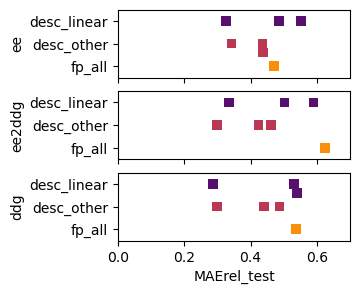

In [236]:
plot_score = "MAErel_test" 
palette = "inferno"

plt.figure(figsize=(3,3))
plt.subplot(3,1,1)
ax = sns.swarmplot(data=overview_sets,x=("ee",plot_score),y="set",
                   marker="s",palette=palette,size=7)
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xticklabels([])
ax.set(xlabel=None)
plt.xlim(0,0.7)
plt.ylabel("ee")
# plt.show()

# plt.figure(figsize=(4,1))
plt.subplot(3,1,2)
ax = sns.swarmplot(data=overview_sets,x=("ee2ddg",plot_score),y="set",legend=False,
                   marker="s",palette=palette,size=7)
ax.set_xticklabels([])
ax.set(xlabel=None)
plt.xlim(0,0.7)
plt.ylabel("ee2ddg")
# plt.show()

# plt.figure(figsize=(4,1))
plt.subplot(3,1,3)
ax=sns.swarmplot(data=overview_sets,x=("ddg",plot_score),y="set",legend=False,
                 marker="s",palette=palette,size=7)
ax.set(xlabel=None)
plt.xlim(0,0.7)
plt.xlabel(plot_score)
plt.ylabel("ddg")
plt.show()

# G-ee curves for demonstration

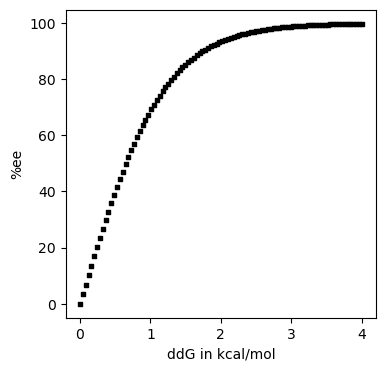

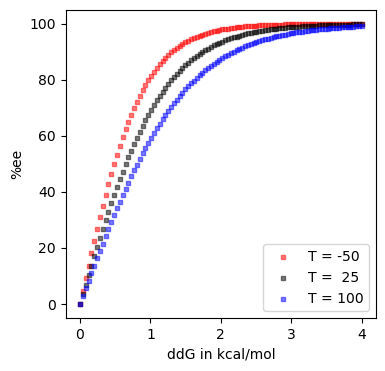

In [123]:
g = np.linspace(0,4,num=100)
ee = g2ee(g)

# ee = np.linspace(0,100,200)
# g = ee2g(ee)

plt.figure(figsize=(4,4))
plt.scatter(g,ee,c="black",marker="s",s=5)
# plt.xlim(0,1.75)
# plt.ylim(0,90)
plt.xlabel("ddG in kcal/mol",fontsize=10)
plt.ylabel("%ee",fontsize=10)
plt.show()

#         plt.scatter(y_train,y_train_pred, label = "train", alpha = 0.5, marker="s", color = "black", s = 10)
#         plt.scatter(y_test,y_test_pred, label = "test", alpha = 0.5, marker="s", color = "red", s = 10)
#         plt.legend(loc='lower right')
#         plt.show()


ee_1 = g2ee(g,-50)
ee_2 = g2ee(g,25)
ee_3 = g2ee(g,100)

plt.figure(figsize=(4,4))
plt.scatter(g,ee_1,c="red",  marker="s",s=5,label="T = -50", alpha=0.5)
plt.scatter(g,ee_2,c="black",marker="s",s=5,label="T =  25", alpha=0.5)
plt.scatter(g,ee_3,c="blue", marker="s",s=5,label="T = 100", alpha=0.5)
# plt.xlim(0,1.75)
# plt.ylim(0,90)
plt.legend()
plt.xlabel("ddG in kcal/mol",fontsize=10)
plt.ylabel("%ee",fontsize=10)
plt.show()

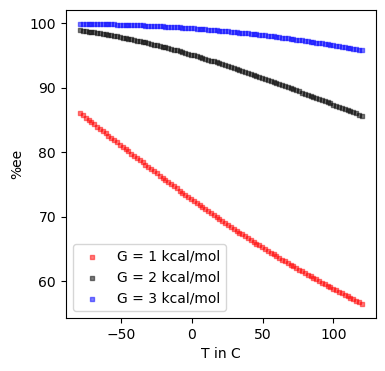

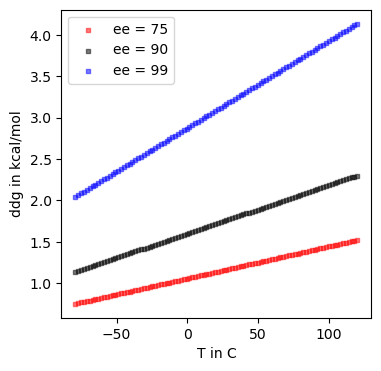

In [121]:
T = np.linspace(-79,120,num=100)
# g = np.ones(100)*3
ee_1 = g2ee(np.ones(100)*1,T)
ee_2 = g2ee(np.ones(100)*2,T)
ee_3 = g2ee(np.ones(100)*3,T)

# ee = np.linspace(0,100,200)
# g = ee2g(ee)

plt.figure(figsize=(4,4))
plt.scatter(T,ee_1,c="red",marker="s",s=5,label="G = 1 kcal/mol", alpha=0.5)
plt.scatter(T,ee_2,c="black",marker="s",s=5,label="G = 2 kcal/mol", alpha=0.5)
plt.scatter(T,ee_3,c="blue",marker="s",s=5,label="G = 3 kcal/mol", alpha=0.5)
# plt.xlim(0,1.75)
# plt.ylim(0,90)
plt.legend()
plt.xlabel("T in C",fontsize=10)
plt.ylabel("%ee",fontsize=10)
plt.show()

T = np.linspace(-79,120,num=100)
# g = np.ones(100)*3
ddg_1 = ee2g(np.ones(100)*75,T)
ddg_2 = ee2g(np.ones(100)*90,T)
ddg_3 = ee2g(np.ones(100)*99,T)

# ee = np.linspace(0,100,200)
# g = ee2g(ee)

plt.figure(figsize=(4,4))
plt.scatter(T,ddg_1,c="red",marker="s",s=5,label="ee = 75", alpha=0.5)
plt.scatter(T,ddg_2,c="black",  marker="s",s=5,label="ee = 90", alpha=0.5)
plt.scatter(T,ddg_3,c="blue", marker="s",s=5,label="ee = 99", alpha=0.5)
# plt.xlim(0,1.75)
# plt.ylim(0,90)
plt.legend()
plt.xlabel("T in C",fontsize=10)
plt.ylabel("ddg in kcal/mol",fontsize=10)
plt.show()